In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import seaborn as sns

sns.set()

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Import Data

In [5]:
ble = read_ble("../Data/ble.csv")
pin = read_pin("../Data/pin.csv")
test_pin = read_pin("../Data/testPin.csv")

In [6]:
def read_sequence_rssi(filename):
    rssi = pd.read_csv(filename)
    rssi = rssi.pivot_table(columns="scanner", values="rssi", index="time")
    rssi.rename_axis(None, axis=1, inplace=True)
    rssi.index = pd.to_datetime(rssi.index)
    rssi = rssi.groupby(pd.Grouper(freq='100ms')).mean()
    return rssi

def read_sequence_loc(filename):
    loc = pd.read_csv(filename)
    loc['time'] = pd.to_datetime(loc['time'])
    loc.set_index('time', inplace=True)
    loc = loc.groupby(pd.Grouper(freq='100ms')).mean()
    return loc

def transform(loc, inplace=False):
    if inplace:
        loc['X'] = 24.187023 + loc['X']
        loc['Y'] = 12.252072 - loc['Y']
    else:
        transformed = pd.DataFrame()
        transformed['X'] = 24.187023 + loc['X']
        transformed['Y'] = 12.252072 - loc['Y']
        return transformed

In [7]:
rssi = read_sequence_rssi('../Data/sequenceRssi_2.csv')
loc = read_sequence_loc('../Data/sequenceLoc_2.csv')

In [8]:
transform(loc, inplace=True)

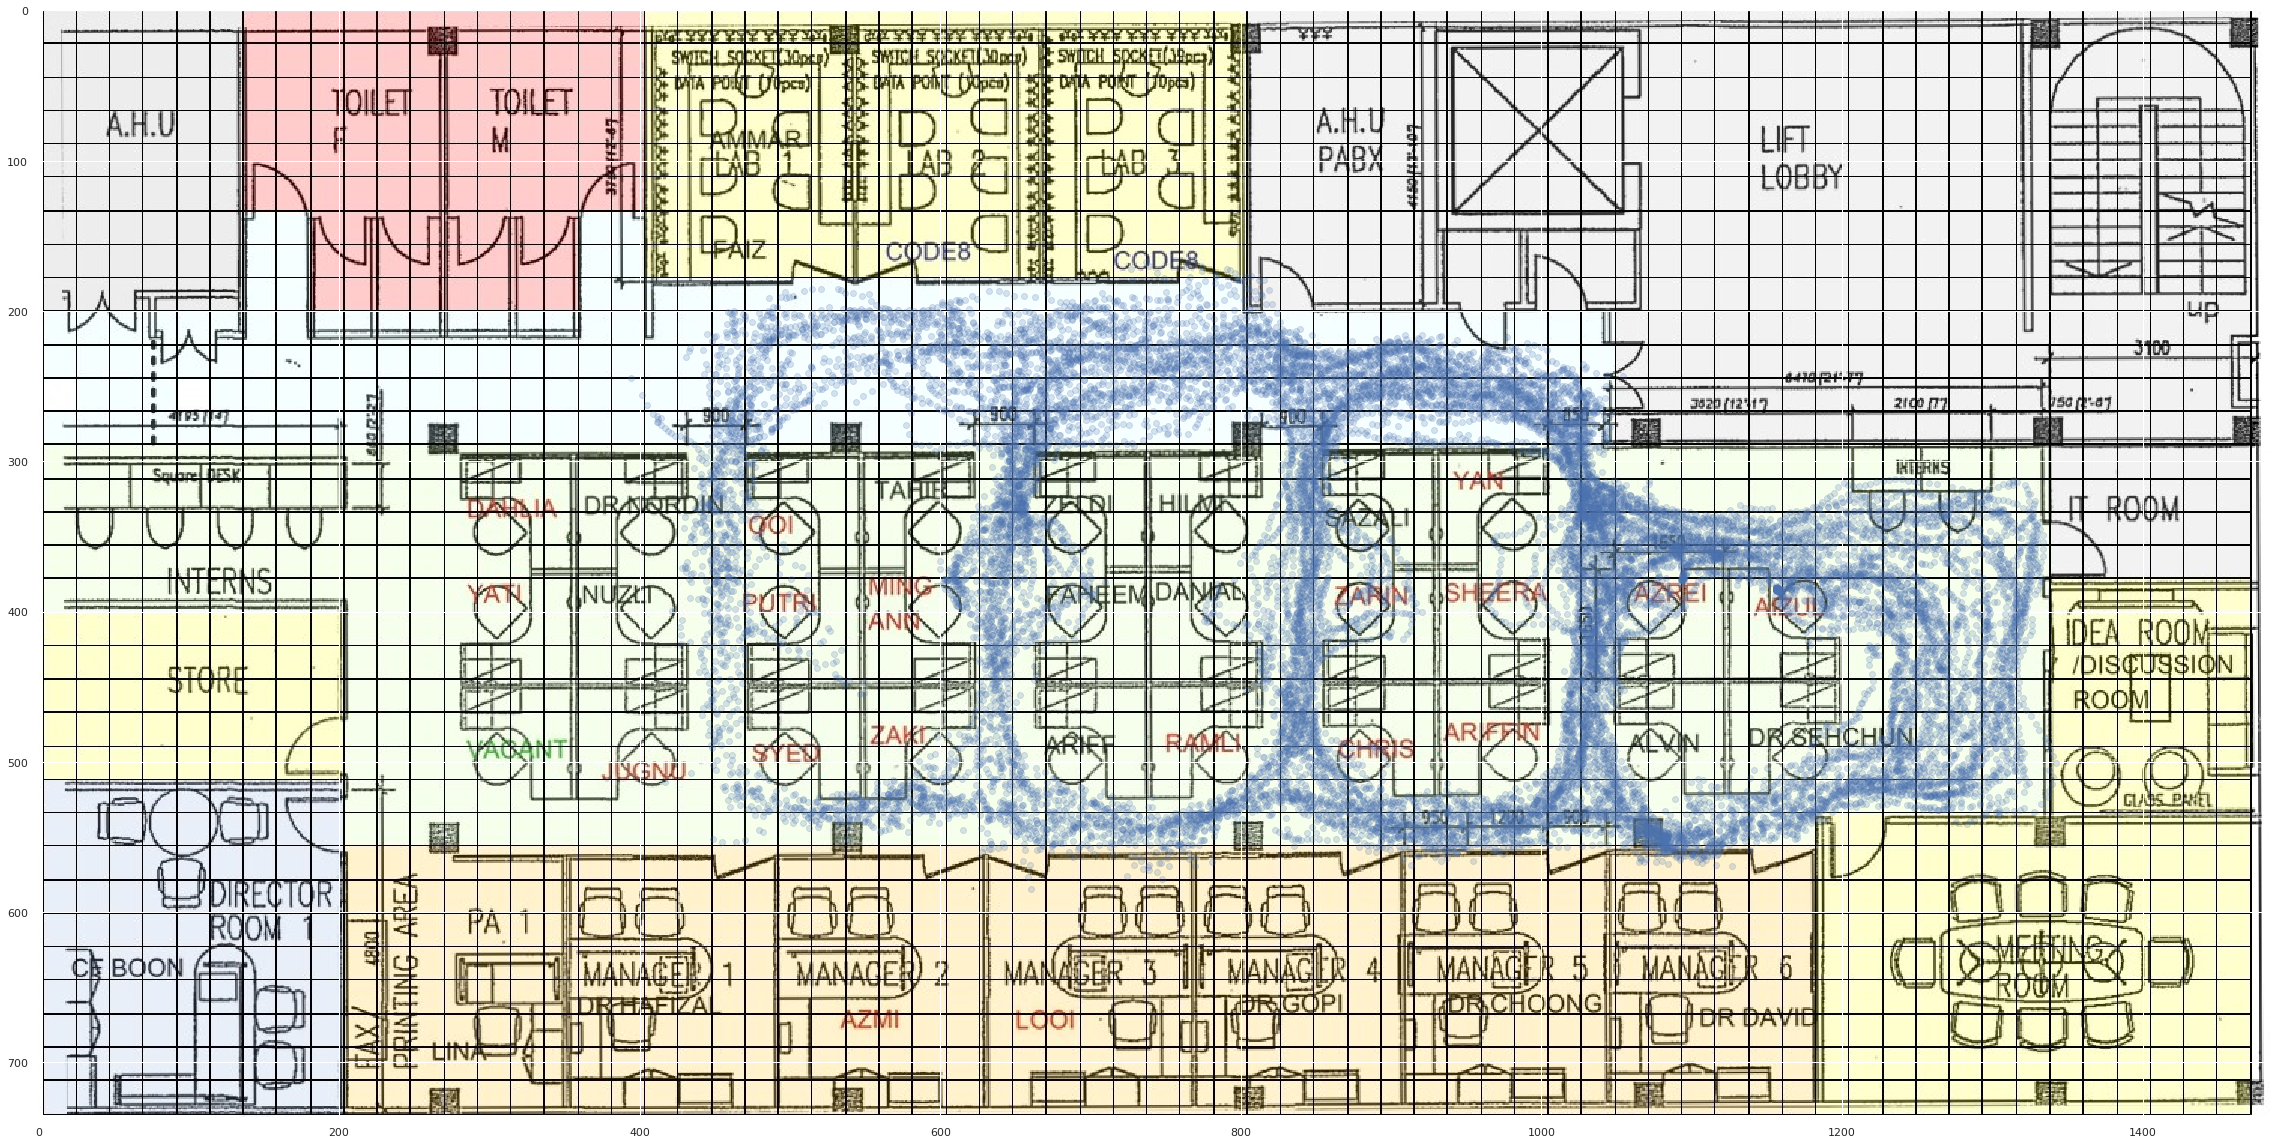

In [9]:
def show_loc(ori_loc):
    img =  mpimg.imread('../Map/main.png')
    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.scatter(ori_loc['X'] * 44, ori_loc['Y'] * 44, alpha=0.2)
    plt.show()
    
show_loc(loc)

In [10]:
data = rssi.join(loc, how='inner')
data.shape

(24099, 19)

In [13]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [14]:
test = pd.concat([test_1, test_2], axis=0)

## Train Validation Split

In [15]:
data

,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,...,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y,location,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-96.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1_32,2019-12-02 01:05:32.956
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-82.0,NaN,NaN,NaN,NaN,NaN,NaN,V1_32,2019-12-02 01:05:32.976
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-72.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1_32,2019-12-02 01:05:33.015
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-79.0,NaN,NaN,NaN,NaN,NaN,NaN,V1_32,2019-12-02 01:05:33.034
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-68.0,NaN,NaN,NaN,V1_32,2019-12-02 01:05:33.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-19 02:08:59.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.373865,8.218641,NaN,NaT
2020-02-19 02:09:00,NaN,NaN,NaN,NaN,-85.0,NaN,NaN,NaN,NaN,NaN,...,NaN,-85.0,NaN,NaN,NaN,NaN,25.394289,8.219140,NaN,NaT
2020-02-19 02:09:00.100000,NaN,NaN,NaN,-83.0,NaN,-61.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.377742,8.222447,NaN,NaT
2020-02-19 02:09:00.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.400523,8.235341,NaN,NaT


In [16]:
n = data.shape[0]

train, validation = data.iloc[:int(0.8 * n),], data.iloc[int(0.8 * n):,]

In [17]:
print(train.shape)
print(validation.shape)

(80920, 21)
(20230, 21)


In [18]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.ffill()
    data_imputed.reset_index(inplace=True)
    linear_impute(data_imputed)
    return data_imputed

def impute_test(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.groupby("location").rolling(rolling_win, min_periods=1).median().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill()
    data_imputed.reset_index(inplace=True)
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [19]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute_test(test)

IndexError: list assignment index out of range

In [ ]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100)
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)

In [ ]:
train_imputed

## PCA

In [ ]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

## Model Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.00001)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 10000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_loss')
]

inputs = tf.keras.Input(shape=(17,))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu')(inputs)
y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

In [ ]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [ ]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

In [ ]:
def cdf(preds, y_test, test_data=False):
    cpin = test_pin if test_data else pin
    plt.figure(figsize=(5, 5))
    for loc in cpin.keys():
        x_selector = np.isclose(y_test[:, 0], cpin[loc]['X'], atol=0.01)
        y_selector = np.isclose(y_test[:, 1], cpin[loc]['Y'], atol=0.01)
        selector = np.logical_and(x_selector, y_selector)
        selector = selector.reshape(-1)
        Z = np.sqrt(np.sum(np.square(preds[selector] - y_test[selector]), axis=1))
        N = Z.size

        X = np.sort(Z)
        F = np.array(range(N)) / float(N)

        plt.plot(X, F, label=loc)
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

In [ ]:
cdf(preds, y_validation)

## Model Testing

In [ ]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

In [ ]:
cdf(preds, y_test, test_data=True)

In [ ]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

test_all = pd.concat([X_test, test_imputed['location']], axis=1)
for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_all[test_all['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()